## 既存のレイヤーにデータを追加する


#### 各種パッケージのインポート

In [2]:
# パッケージ等 import 処理
import urllib.request
from arcgis.gis import GIS
from arcgis.features import FeatureLayerCollection as FLC
import pandas as pd
import datetime

import pytz

#### ArcGIS Online にログイン


In [3]:
# ArcGIS Onlineにログイン
gis = GIS(url=portal,username=user_name,password=user_pass)
gis

GIS @ https://ej.maps.arcgis.com version:9.4

#### 追加データのクレンジング

In [4]:
# 登録用の日時を取得する
now_datetime = datetime.datetime.now(pytz.timezone('Asia/Tokyo'))
now = now_datetime.strftime("%Y%m%d_%H%M")

In [5]:
# 座標結合用のデータを取得する
amedas_location = pd.read_csv('/arcgis/home/アメダス座標一覧.csv')

# 気象庁からアメダスの 1 時間ごとのデータをダウンロード
url = "https://www.data.jma.go.jp/obd/stats/data/mdrr/pre_rct/alltable/pre1h00_rct.csv"
dataFile = "/arcgis/home/" + now + ".csv"
urllib.request.urlretrieve(url, dataFile)

# 取得したファイルから、観測所番号と降雨量の現在値のみ取得
amedasdata = pd.read_csv(dataFile, encoding = "shift-jis", usecols=["観測所番号", "現在値(mm)"])
# 座標結合用のファイルと結合しつつ、降雨量が 1mm より多いデータのみ抽出する
result=pd.merge(amedas_location,amedasdata[amedasdata['現在値(mm)'] > 1], on='観測所番号', how="inner")

# 作成日時列を追加する
result["作成日時"] = now_datetime.strftime("%Y/%m/%d %H:%M:%S")

In [6]:
## 追加用 CSV を出力する
amedasCSV = ('/arcgis/home/' + now +'.csv')
result.to_csv(amedasCSV)

In [7]:
# CSV ファイルのアップロード
title = "appendData"+ now
tags = "test"
itemtype = "CSV"
item_props = {"type":itemtype,"tags":tags,"title":title}

append_CSV = gis.content.add(item_properties = item_props, data = amedasCSV)
append_CSV

<Item title:"appendData20220112_1945" type:CSV owner:ejnagaiA>

#### 更新対象のフィーチャ レイヤーを取得する

<Item title:"アメダステスト" type:Feature Layer Collection owner:ejnagaiA>
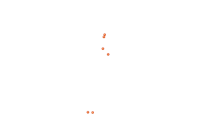

In [8]:
item = gis.content.search(query="title : アメダステスト type : Feature Service")[0]
item

In [9]:
## データを追加する Feature Layer を取得
fl = item.layers[0]
fl

<FeatureLayer url:"https://services.arcgis.com/wlVTGRSYTzAbjjiC/arcgis/rest/services/アメダステスト/FeatureServer/0">

#### 追加処理の実行

In [10]:
fl.append(
    item_id = append_CSV.id,
    upload_format="csv",
    upsert=False,
    source_info =gis.content.analyze(item = append_CSV.id)['publishParameters']
)

True